# Homework 2

In this homework, we will explore a small dataset of 60 songs annotated with emotion using GEMS model. You received a folder with music files (one minute excerpts), a folder with automatically extracted chords that were parsed for you into chord root, chord triad type and chord extension, and emotional annotations in a CSV file.


Prerequisites: install **pandas, scikit learn**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

In [2]:
"""

    where am i?

"""

PATH = os.getcwd() + '/'

ch_path = PATH + 'chords/'
mu_path = PATH + 'music/'

print(f'PATH: {PATH}')
print(f'chords path: {ch_path}')
print(f'music path: {mu_path}')

PATH: /Users/no_lineal/Documents/GitHub/music_information_retrieval/hw02/
chords path: /Users/no_lineal/Documents/GitHub/music_information_retrieval/hw02/chords/
music path: /Users/no_lineal/Documents/GitHub/music_information_retrieval/hw02/music/


#### <font color='red'> Exercise 1 (3 points). Design and extract some features based on the extracted chords (you might try number of unique chords or chord stems, consider summing up chord durations for a specific chord type, etc.) </font>

In [3]:
"""

    load data

"""

mu_ss = sorted(os.listdir( mu_path ))
ch_ss = sorted(os.listdir( ch_path ))

print(f'lenght sample space: { len(mu_ss) }')
print(f'lenght chord sample space: { len(ch_ss) }')

lenght sample space: 60
lenght chord sample space: 60


In [4]:
"""

    sample chords

"""

sample = np.random.choice( ch_ss ) 

print(f'sample: {sample}')

example_chord_file = pd.read_csv( ch_path + sample )
example_chord_file.head()

sample: 202.csv


chord chord_root chord_triad chord_addition  chord_duration
0  Em7b5          E         m7b              5        2.925714
1  Gm7b5          G         m7b              5        7.337506
2    Ebm         Eb           m           None       10.681179
3     F#         F#        None           None        0.789478
4    Ebm         Eb           m           None        1.718277

In [5]:
"""

    complete chords

"""

ch_df = pd.DataFrame()

for s in tqdm(ch_ss):
    
    if ch_df.empty:
        
        aux = pd.read_csv( ch_path + s )
        aux['sample'] = s.replace('.csv', '')
        
        ch_df = aux
        
    else:
        
        aux = pd.read_csv( ch_path + s )
        aux['sample'] = s.replace('.csv', '')
        
        ch_df = pd.concat( [ ch_df, aux ], axis=0 )
        
miss = set([ x.replace('.csv', '') for x in ch_ss ]) - set(ch_df['sample'].unique())

print(f'samples chords: {ch_df["sample"].nunique()}')
print(f'missing chords from: { miss }')

ch_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 1005.36it/s]

samples chords: 59
missing chords from: {'206'}


chord chord_root chord_triad chord_addition  chord_duration sample
0      C#m         C#           m           None        0.046440      1
1      F#6         F#        None              6        2.507755      1
2       Eb         Eb        None           None        0.975238      1
3      C#m         C#           m           None        1.346757      1
4       F#         F#        None           None        1.950476      1
..     ...        ...         ...            ...             ...    ...
31   Cm7b5          C         m7b              5        1.486077      9
32      F7          F        None              7        1.021678      9
33     Bbm         Bb           m           None        2.600635      9
34    Ebm6         Eb           m              6        2.554195      9
35  C#maj7         C#         maj              7        1.300317      9

[1679 rows x 6 columns]

In [6]:
"""

    features

"""

print(f'total number of chords: {ch_df["chord"].nunique()}')
print(f'total number of root chords: {ch_df["chord_root"].nunique()}')

ch_features = pd.DataFrame()

# number of chords normalized with respect to the chords observed in the corpus

ch_features = ch_df.groupby(['sample'])['chord'].nunique().reset_index().copy()
ch_features['chord_norm'] = ch_features['chord'] / ch_df['chord'].nunique()

# number of chords normalized with respect to the root chords observed in the corpus

aux = ch_df.groupby(['sample'])['chord_root'].nunique().reset_index().copy()
aux['chord_root_norm'] = aux['chord_root'] / ch_df['chord_root'].nunique()

ch_features = ch_features.merge(aux, on='sample', how='right')

# chords duration

aux = ch_df.groupby(['sample', 'chord_root'])['chord_duration'].sum().reset_index(name='duration')
aux['total'] = aux.groupby('sample')['duration'].transform('sum')
aux['norm_duration'] = aux['duration'] / aux['total']
aux = aux.pivot( index='sample', columns='chord_root', values='norm_duration' ).reset_index().fillna(0.0)
aux.columns = [ x + '_d' if x != 'sample' else 'sample' for x in aux.columns ]

ch_features = ch_features.merge(aux, on='sample', how='right')

# chords representation

aux = ch_df.groupby(['sample', 'chord_root']).size().reset_index(name='count')
aux['total'] = aux.groupby('sample')['count'].transform('sum')
aux['norm_count'] = aux['count'] / aux['total']
aux = aux.pivot(index='sample', columns='chord_root', values='norm_count').reset_index().fillna(0.0)
ch_features = ch_features.merge( aux, on='sample', how='right' )

ch_features['sample'] = ch_features['sample'].astype('int')
ch_features.sort_values(by=['sample'])

features = [ x for x in ch_features if x not in ['sample'] ]

print(f'features: \n{features}')
ch_features.head()

total number of chords: 113
total number of root chords: 12
features: 
['chord', 'chord_norm', 'chord_root', 'chord_root_norm', 'A_d', 'Ab_d', 'B_d', 'Bb_d', 'C_d', 'C#_d', 'D_d', 'E_d', 'Eb_d', 'F_d', 'F#_d', 'G_d', 'A', 'Ab', 'B', 'Bb', 'C', 'C#', 'D', 'E', 'Eb', 'F', 'F#', 'G']


sample  chord  chord_norm  chord_root  chord_root_norm       A_d      Ab_d  \
0       1     30    0.265487          10         0.833333  0.059247  0.183347   
1      10     14    0.123894           7         0.583333  0.000000  0.475645   
2     101     18    0.159292           6         0.500000  0.279272  0.000000   
3     102     12    0.106195           5         0.416667  0.000000  0.000000   
4     103     13    0.115044           8         0.666667  0.261277  0.000000   

        B_d      Bb_d       C_d  ...         B        Bb         C        C#  \
0  0.034428  0.019215  0.013611  ...  0.063830  0.021277  0.021277  0.212766   
1  0.021968  0.048711  0.030564  ...  0.026316  0.078947  0.026316  0.210526   
2  0.034019  0.075949  0.162975  ...  0.048780  0.048780  0.097561  0.000000   
3  0.046603  0.000000  0.487362  ...  0.035714  0.000000  0.357143  0.000000   
4  0.211064  0.000000  0.057021  ...  0.192308  0.000000  0.076923  0.000000   

          D         E        Eb         F        F#         G  
0  0.000000  0.106383  0.106383  0.000000  0.212766  0.021277  
1  0.000000  0.052632  0.236842  0.000000  0.000000  0.000000  
2  0.341463  0.000000  0.000000  0.073171  0.000000  0.000000  
3  0.107143  0.107143  0.000000  0.000000  0.000000  0.392857  
4  0.000000  0.230769  0.076923  0.038462  0.076923  0.153846  

[5 rows x 29 columns]

In [7]:
#feature_list=[]
#chordfiles = os.listdir("chords")
#for filename in chordfiles: 
#    chords = pd.read_csv(os.path.join("chords", filename), sep=',')
    #... design at least 5 features based on chords here 
    
#    feature1 = ...
#    feature2 = ...
#    feature3 = ...
#    feature4 = ...
#    feature5 = ...
    
#    song_file_id = filename.split(".")[0] + '.mp3'
#    feature_list.append([song_file_id, feature1, feature2, feature3, feature4, feature5])

# create a dataframe with your features
#features = pd.DataFrame(feature_list, columns = ['filename','feature1', 'feature2', ... ])

#### <font color='red'> Exercise 2 (2 points). Cluster the music files based on your features. You can choose a different number of clusters. Then listen to the music and look at the cluster statistics and describe your clusters. </font>

In [8]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import plotly.express as px
import plotly.graph_objects as go

# we remove the file ids from cluster variables
features_without_labels = ch_features[ features ].copy()

# Choose your n_clusters here
kmeans = KMeans(n_clusters=3, random_state=0).fit(features_without_labels)

print(f'number of clusters: {len(set(kmeans.labels_))}')
kmeans.labels_

number of clusters: 3


/Users/no_lineal/opt/anaconda3/envs/music38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 2, 2, 2], dtype=int32)

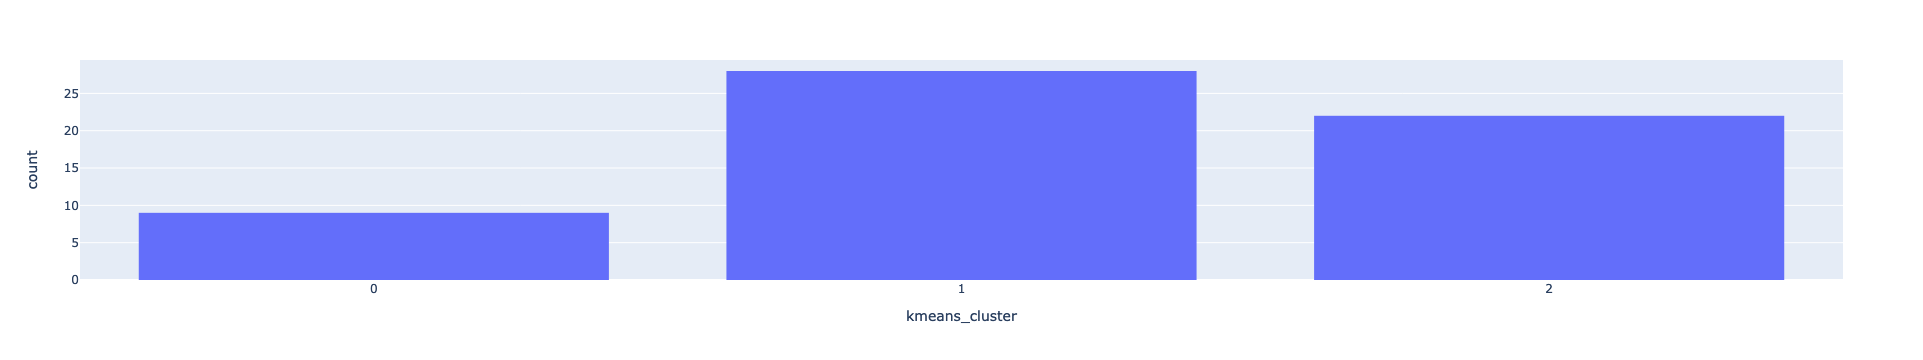

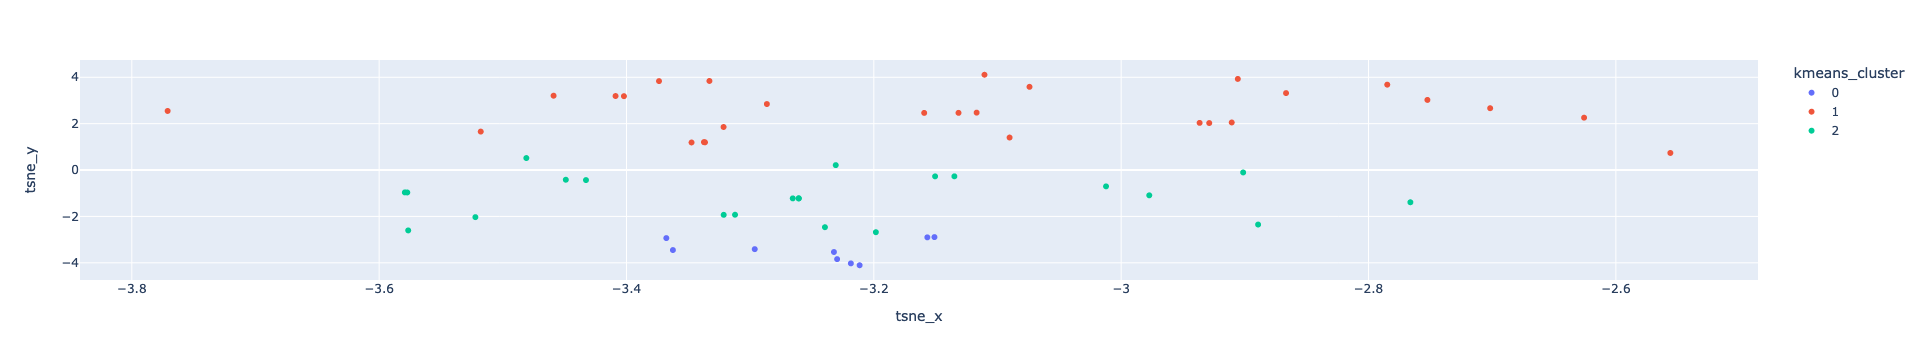

In [9]:
#cluster_with_song_ids = pd.DataFrame(
#    {'sample': ch_features['sample'].values,
#     'KMeans_clusters': kmeans.labels_})

#print("Cluster 1")
#print(cluster_with_song_ids[cluster_with_song_ids.KMeans_clusters==1]["song_ids"])

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
df_tsne = tsne.fit_transform(ch_features[ features ].iloc[:, :-1])

# Add t-SNE components to dataframe
ch_features['tsne_x'] = df_tsne[:, 0]
ch_features['tsne_y'] = df_tsne[:, 1]
ch_features['kmeans_cluster'] = kmeans.labels_
ch_features['kmeans_cluster'] = ch_features['kmeans_cluster'].astype('str')
ch_features = ch_features.sort_values(by=['kmeans_cluster'])

# histogram clusters
fig = px.histogram(ch_features, x='kmeans_cluster')
fig.show()

# tsne viz
fig = px.scatter(ch_features, x='tsne_x', y='tsne_y', color='kmeans_cluster')
fig.show()

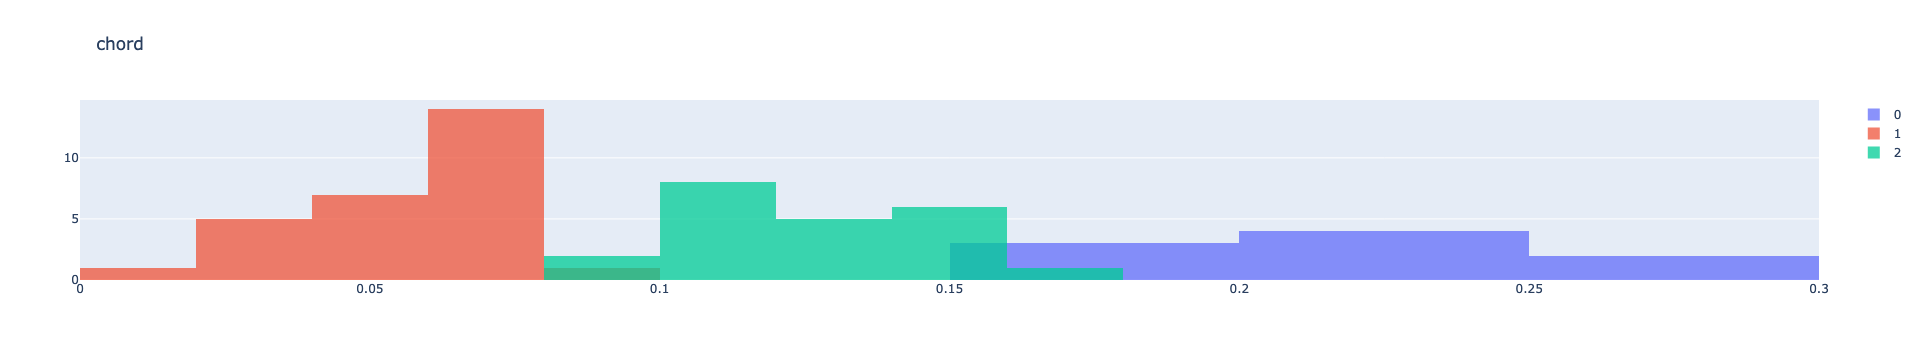

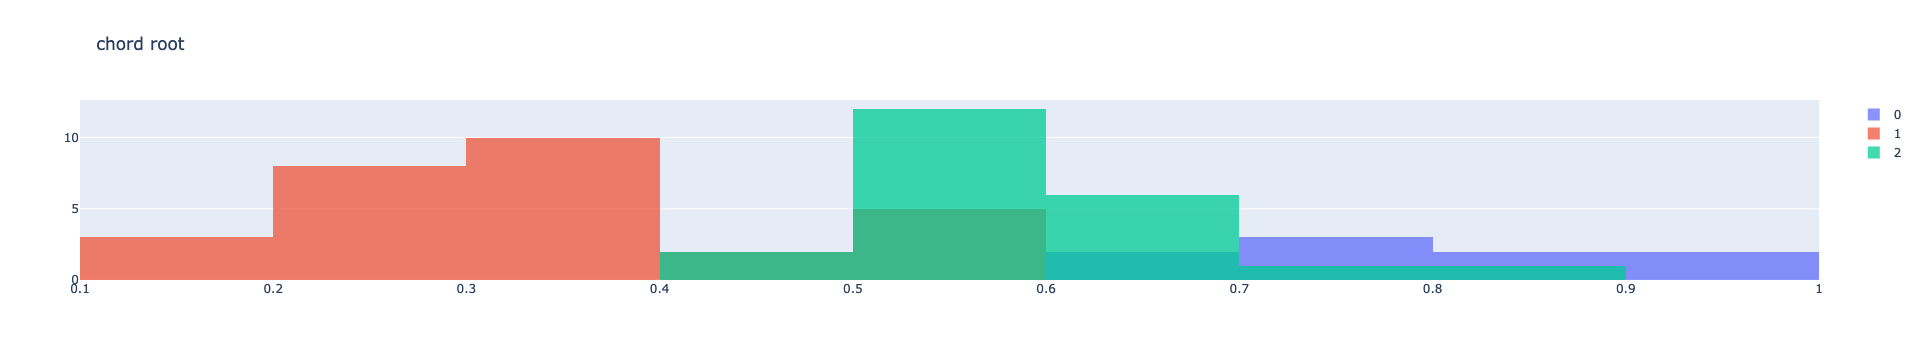

In [10]:
"""

    feature viz

"""

fig = go.Figure()

for c in ch_features['kmeans_cluster'].unique():
    
    fig.add_trace( go.Histogram( x=ch_features[ ch_features['kmeans_cluster'] == c ]['chord_norm'], name=str(c) ) )
    
# Overlay both histograms
fig.update_layout(barmode='overlay', title='chord')
fig.update_traces(opacity=0.75)
fig.show()

fig = go.Figure()

for c in ch_features['kmeans_cluster'].unique():
    
    fig.add_trace( go.Histogram( x=ch_features[ ch_features['kmeans_cluster'] == c ]['chord_root_norm'], name=str(c) ) )
    
# Overlay both histograms
fig.update_layout(barmode='overlay', title='chord root')
fig.update_traces(opacity=0.75)
fig.show()

In [11]:
"""

    random sampling

"""

from IPython.display import Audio

for c in ch_features['kmeans_cluster'].unique():
    
    aux = ch_features[ ch_features['kmeans_cluster'] == c ]
    sample = str(np.random.choice( aux['sample'].unique() )) + '.mp3'
    
    print(f'sample from cluster {c}: {sample}')
    display(Audio( mu_path + sample, autoplay=False ))

sample from cluster 0: 104.mp3


sample from cluster 1: 311.mp3


sample from cluster 2: 204.mp3


#### <font color='red'> Listen to the songs in your clusters and describe the clusters that you found. What characteristics do they have? </font>

**After fitting the data using k-means with three clusters, we found that one of them represents classical music, while clusters [1, 2] were more difficult to separate according to the heuristics. However, by observing the chords that describe each sample, it can be observed that there exists a threshold between the type of chords and the time each of them is used during the piece.**

**I used t-SNE to project the feature space into two dimensions and it can be observed that the transition between labels is very smooth. Thus, we can compare the difference between the extreme clusters and it can be heard that the energy in the music goes from peaceful to a more energetic feel**

#### <font color='red'> Exercise 3 (3 points). Now use your extracted features to predict one or more of the emotional dimensions of your choice. </font>

In [12]:
emotion_annotations = pd.read_csv("emotion_annotations.csv")
emotion_annotations = emotion_annotations.rename(columns={'song_id': 'sample'})
emotion_annotations['sample'] = emotion_annotations['sample'].apply( lambda x: x.replace('.mp3', '') )

ch_features['sample'] = ch_features['sample'].astype(str)
features_with_emotion = emotion_annotations.merge(ch_features, on='sample', how='left').dropna()

print(emotion_annotations.head())
features_with_emotion.loc[0]

  sample  amazement  solemnity  tenderness  nostalgia  calmness   power  \
0      1     0.1842     0.3684      0.1842     0.2632    0.7105  0.0263   
1      2     0.1220     0.1951      0.4634     0.3415    0.7073  0.0488   
2      3     0.2162     0.2973      0.1351     0.2162    0.0811  0.2973   
3      4     0.1429     0.1429      0.5429     0.4286    0.8000  0.0286   
4      5     0.0541     0.3243      0.2973     0.5135    0.3243  0.0270   

   joyful_activation  tension  sadness  
0             0.1053   0.0526   0.2632  
1             0.0244   0.0244   0.0976  
2             0.4324   0.1892   0.1351  
3             0.0000   0.0000   0.1143  
4             0.0811   0.2162   0.2703  


sample                      1
amazement              0.1842
solemnity              0.3684
tenderness             0.1842
nostalgia              0.2632
calmness               0.7105
power                  0.0263
joyful_activation      0.1053
tension                0.0526
sadness                0.2632
chord                    30.0
chord_norm           0.265487
chord_root               10.0
chord_root_norm      0.833333
A_d                  0.059247
Ab_d                 0.183347
B_d                  0.034428
Bb_d                 0.019215
C_d                  0.013611
C#_d                 0.183347
D_d                       0.0
E_d                  0.091273
Eb_d                 0.138511
F_d                       0.0
F#_d                 0.260208
G_d                  0.016813
A                     0.06383
Ab                   0.170213
B                     0.06383
Bb                   0.021277
C                    0.021277
C#                   0.212766
D                         0.0
E         

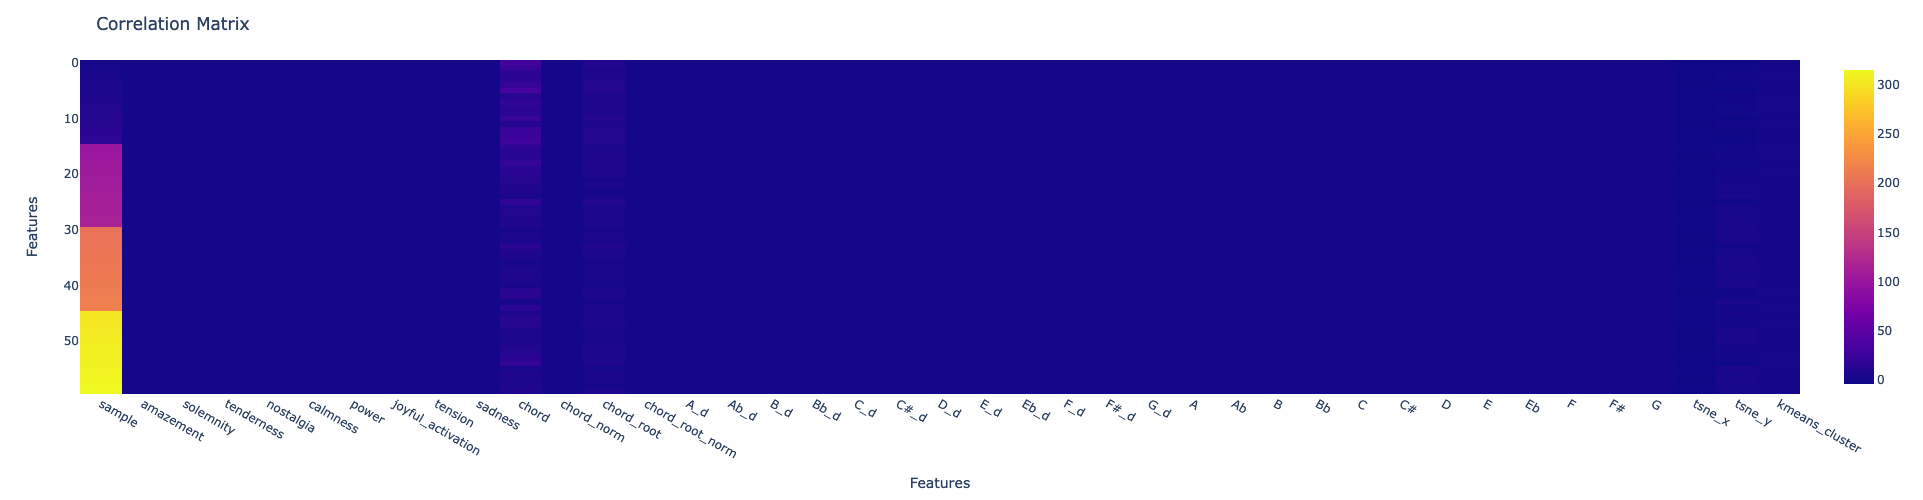

In [13]:
corr_mat = features_with_emotion

fig = px.imshow(
    corr_mat,
    x=corr_mat.columns,
    y=corr_mat.index
)

fig.update_layout(
    title='Correlation Matrix',
    width=500,
    height=500,
    xaxis_title='Features',
    yaxis_title='Features'
)

fig.show()

#### <font color='red'> Train a model of your choice and evaluate it's performance</font>

mean MSE for 10 folds : 0.036208679830841486
standard deviation for 10 folds: 0.012480853811439412


  0%|          | 0/59 [00:00<?, ?it/s]

----------- amazement -----------


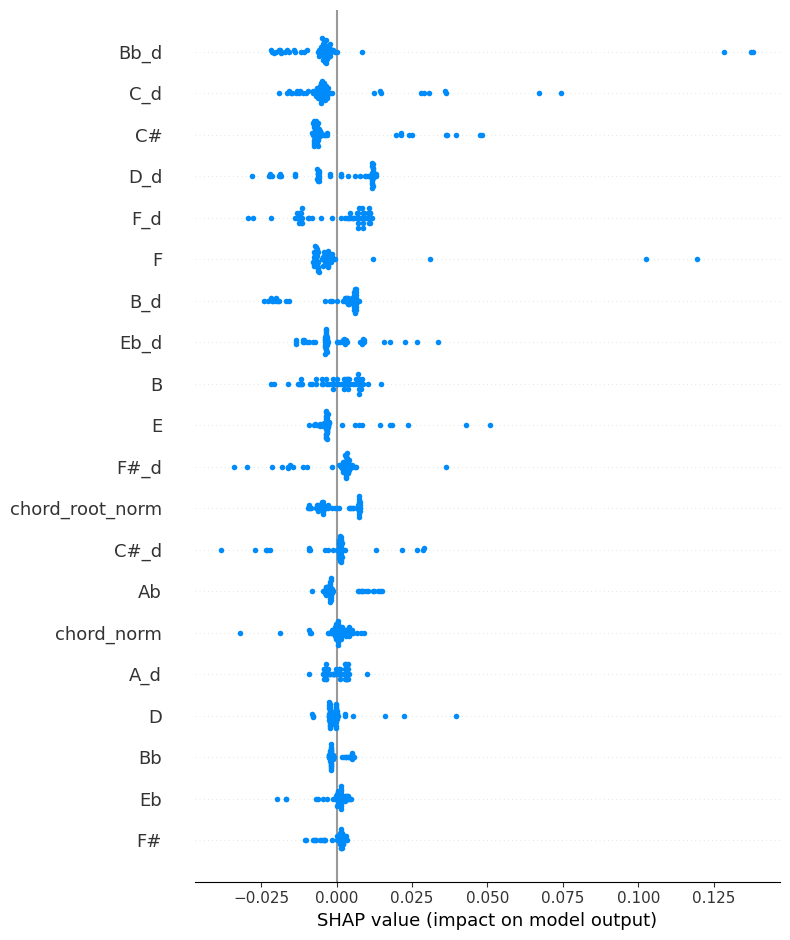

----------- solemnity -----------


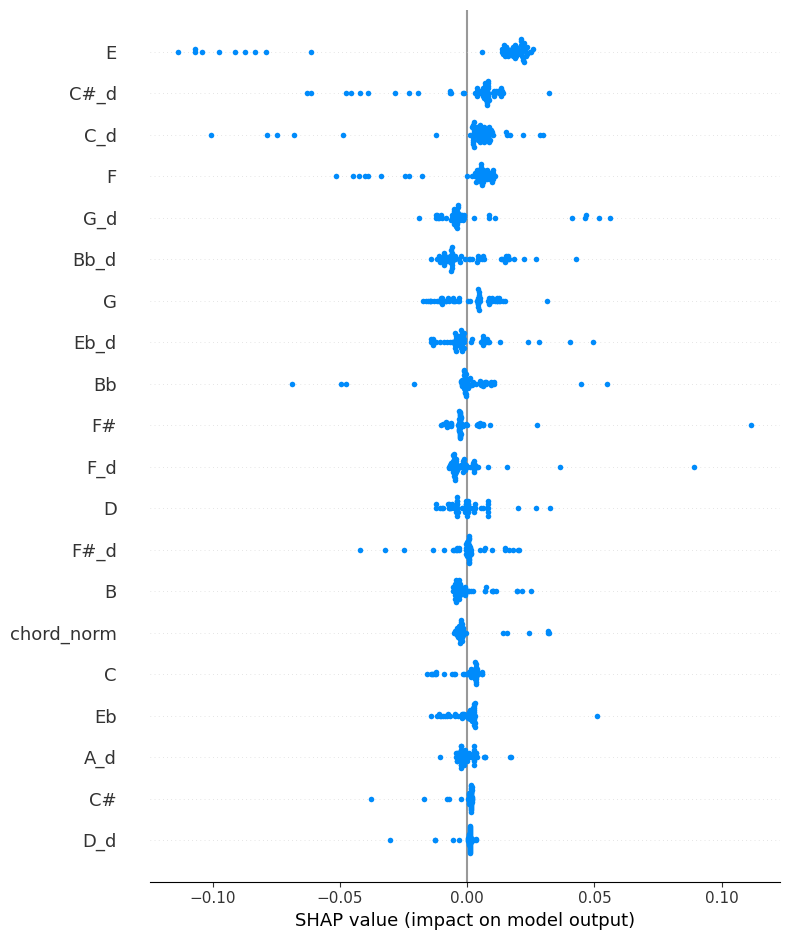

----------- tenderness -----------


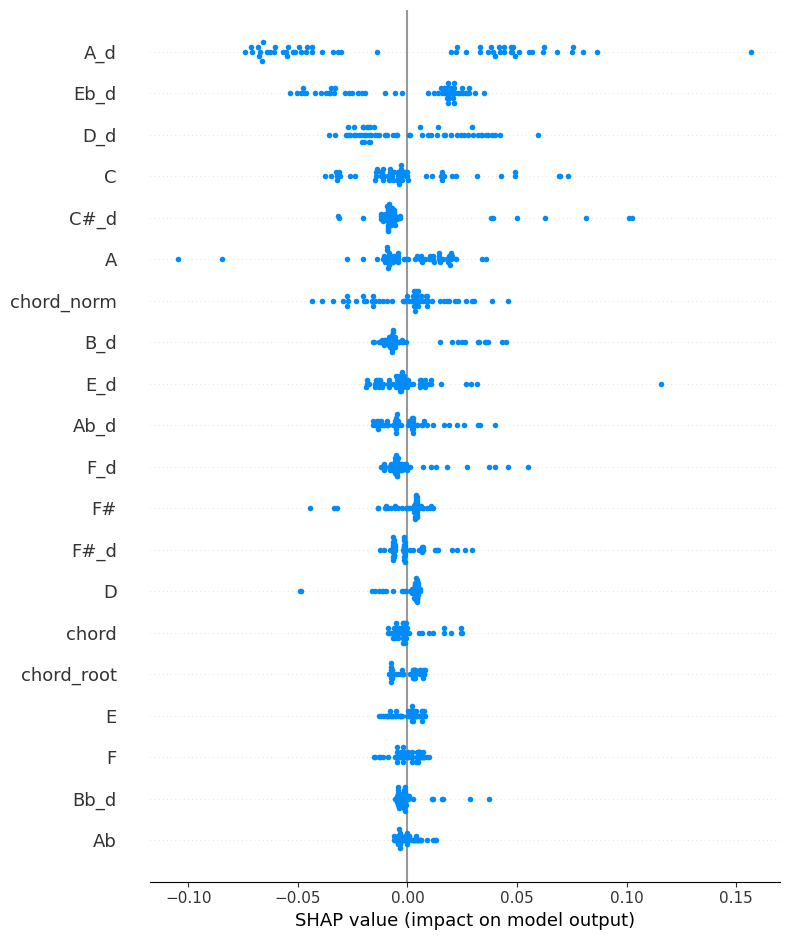

----------- nostalgia -----------


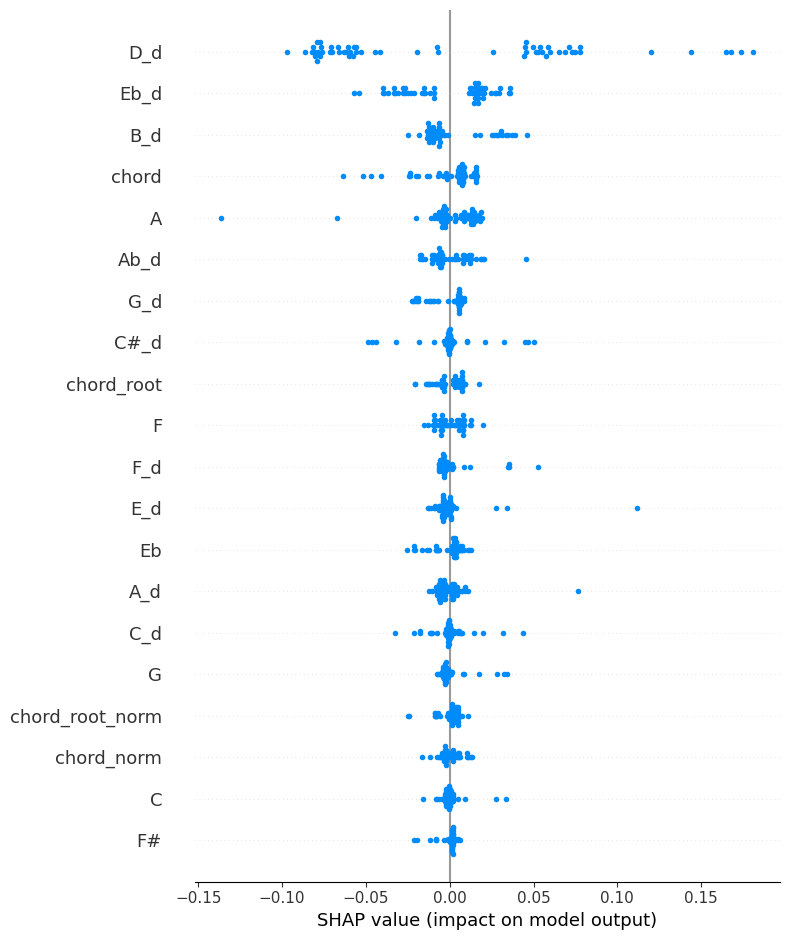

----------- calmness -----------


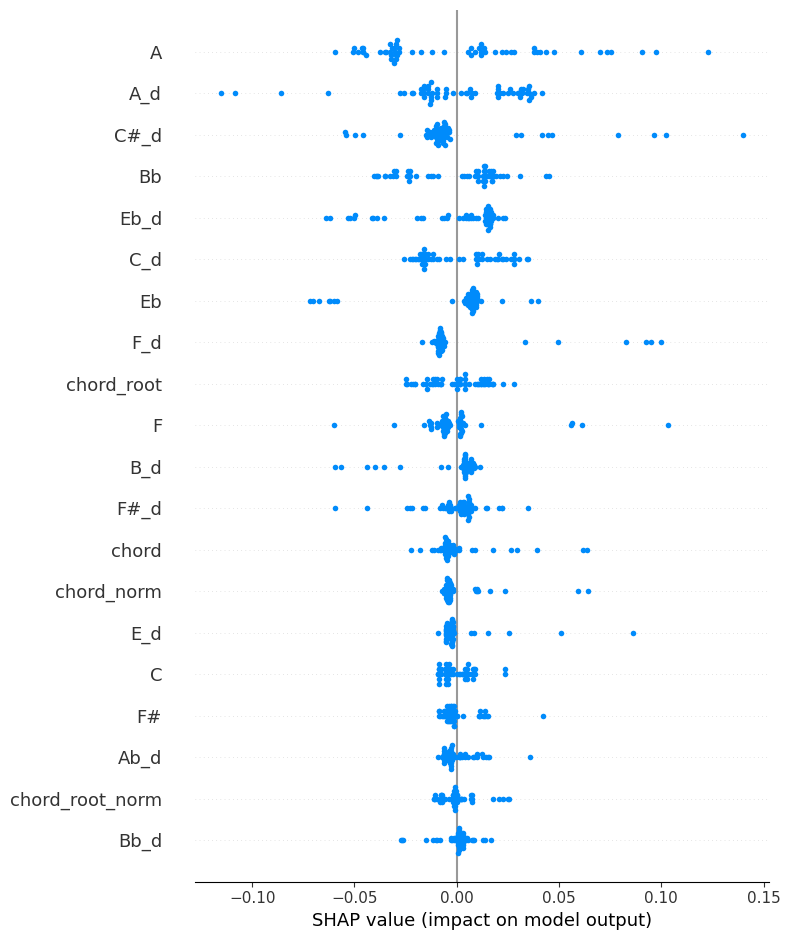

----------- power -----------


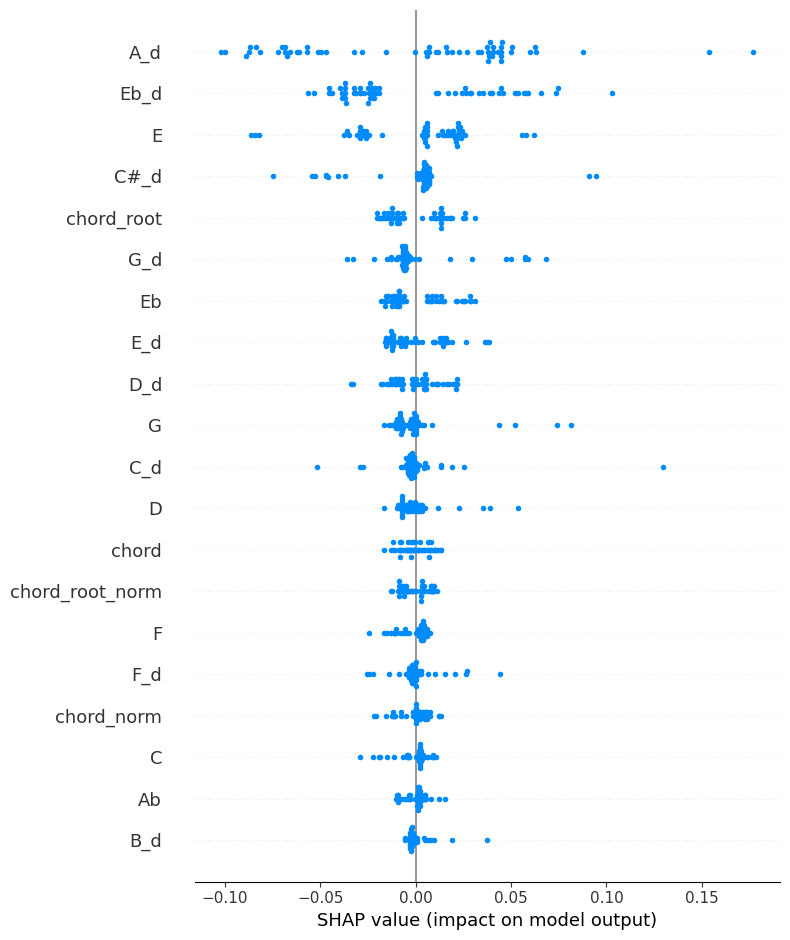

----------- joyful_activation -----------


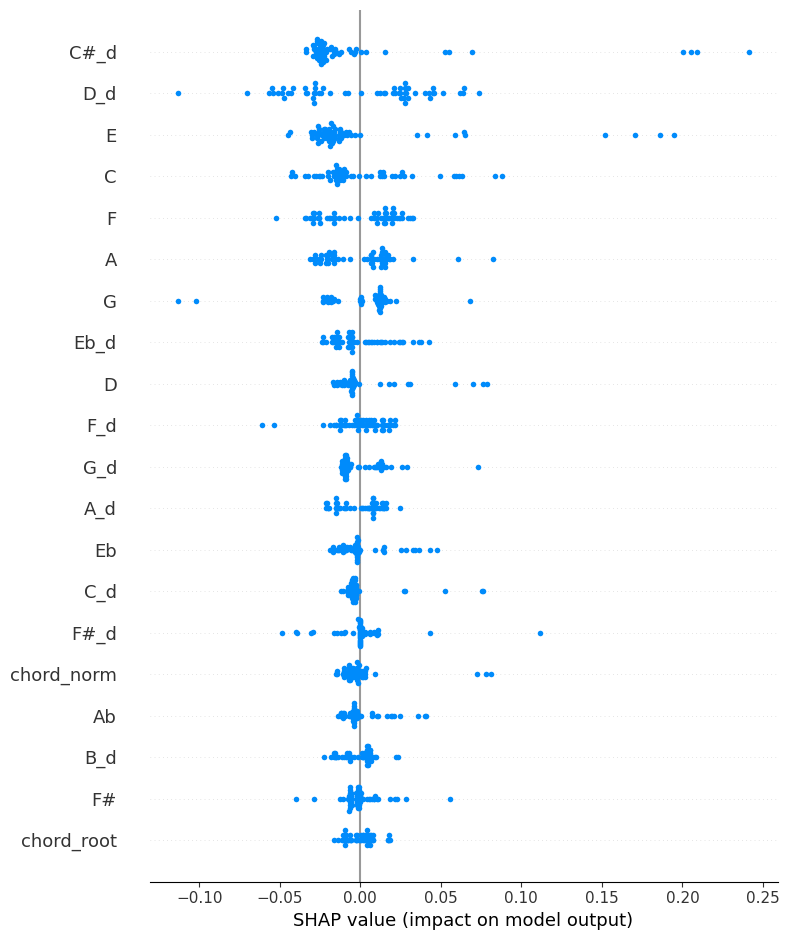

----------- tension -----------


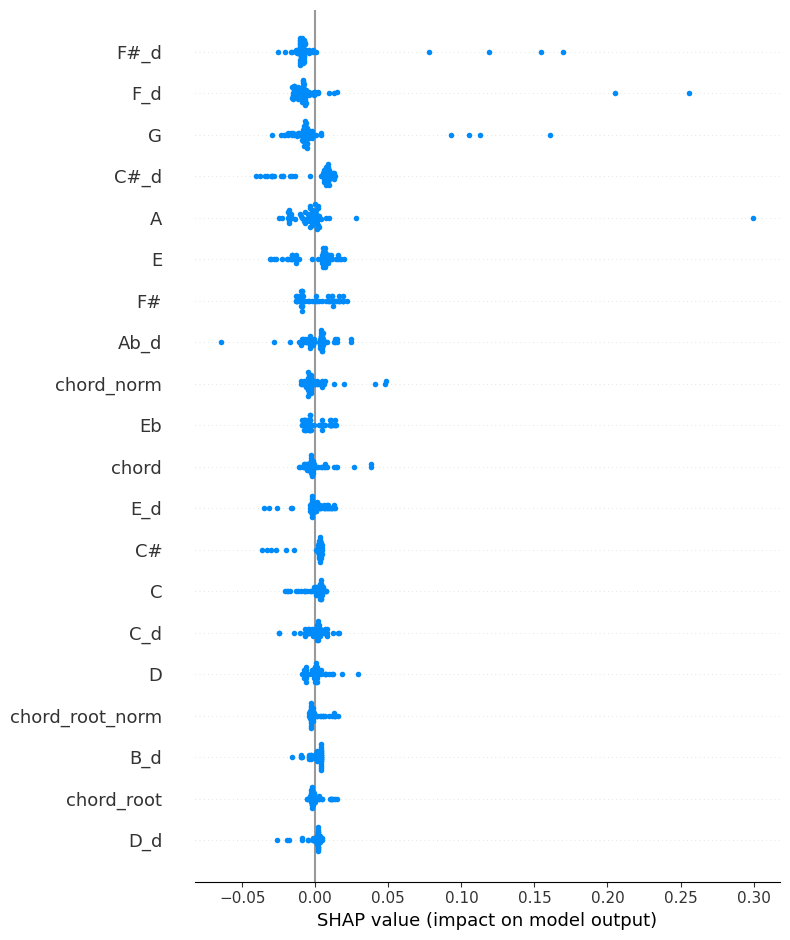

----------- sadness -----------


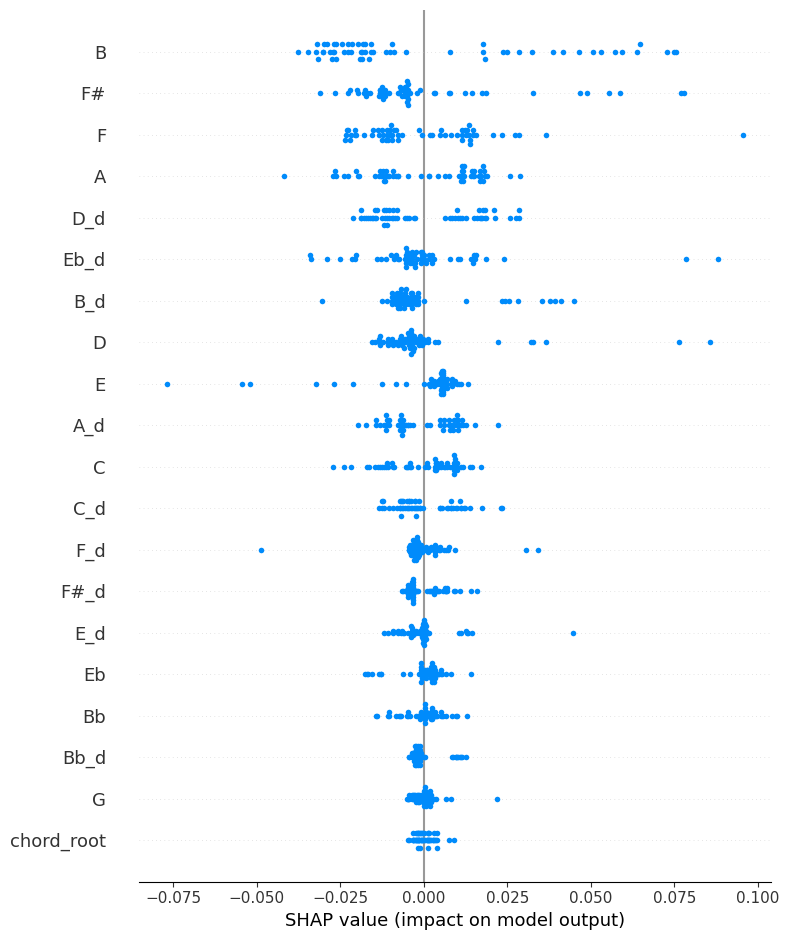

In [14]:
#add model here
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import shap
import seaborn as sns

shap.initjs()

X = features_with_emotion[ features ].values
y = features_with_emotion[ [ x for x in emotion_annotations if x not in ['sample'] ] ].values

multi_regressor = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))

# perform k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# validation
mse_scores = []
for train_idx, test_idx in kf.split(X):
    
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    multi_regressor.fit(X_train, y_train)
    
    y_pred = multi_regressor.predict(X_test)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    
# print the mean and standard deviation of the MSE scores
print("mean MSE for 10 folds :", np.mean(mse_scores))
print("standard deviation for 10 folds:", np.std(mse_scores))

# fit all dataset
model = multi_regressor.fit(X, y)

# feature importance
explainer = shap.KernelExplainer(model=model.predict, data=X, link="identity")
shap_values = explainer.shap_values(X=X)

n = 0
for i in [ x for x in emotion_annotations if x not in ['sample'] ]:
    
    print(f'----------- {i} -----------')
    shap.summary_plot(shap_values=shap_values[ n ], features=features)
    
    n += 1

#### <font color='red'> What were your best features?  </font>

**The best features depends nin the context 

#### <font color='red'> How long did it take you to do this homework? Do you have any comments on how to improve it? </font>

Add your answer here.